<a href="https://colab.research.google.com/github/MWFK/TensorFlow-Certificate-study-materials/blob/main/10.%20Apply_DNN_to_Sarcasm_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import io
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-08-08 14:44:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-08-08 14:44:05 (220 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    # There is a part for embedding_dim explanation https://www.youtube.com/watch?v=-8XmD2zsFBI
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Average Pooling is a pooling operation that calculates the average value for patches of a feature map, and uses it to create a downsampled (pooled) feature map. 
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(x=training_padded, y=training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6585 - accuracy: 0.6007 - val_loss: 0.5613 - val_accuracy: 0.7371
Epoch 2/30
625/625 - 2s - loss: 0.4212 - accuracy: 0.8339 - val_loss: 0.3809 - val_accuracy: 0.8432
Epoch 3/30
625/625 - 2s - loss: 0.3066 - accuracy: 0.8781 - val_loss: 0.3571 - val_accuracy: 0.8463
Epoch 4/30
625/625 - 2s - loss: 0.2559 - accuracy: 0.9012 - val_loss: 0.3439 - val_accuracy: 0.8572
Epoch 5/30
625/625 - 2s - loss: 0.2199 - accuracy: 0.9153 - val_loss: 0.3457 - val_accuracy: 0.8563
Epoch 6/30
625/625 - 2s - loss: 0.1935 - accuracy: 0.9280 - val_loss: 0.3586 - val_accuracy: 0.8557
Epoch 7/30
625/625 - 2s - loss: 0.1731 - accuracy: 0.9355 - val_loss: 0.3703 - val_accuracy: 0.8504
Epoch 8/30
625/625 - 2s - loss: 0.1528 - accuracy: 0.9445 - val_loss: 0.3819 - val_accuracy: 0.8538
Epoch 9/30
625/625 - 2s - loss: 0.1395 - accuracy: 0.9503 - val_loss: 0.3976 - val_accuracy: 0.8523
Epoch 10/30
625/625 - 2s - loss: 0.1257 - accuracy: 0.9555 - val_loss: 0.4176 - val_accuracy: 0.8499

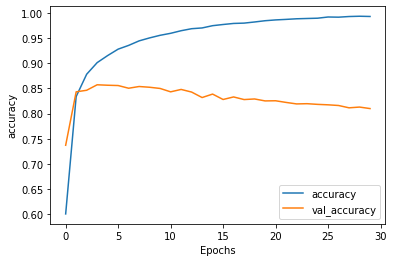

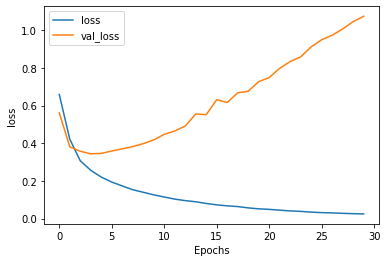

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.6868348e-01]
 [1.4166011e-05]]


# Word Weights

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(word_index)
print(reverse_word_index, '\n')

print(training_padded[0])
print(decode_sentence(training_padded[0]), '\n')

print(training_sentences[2])
print(labels[2])

{'<OOV>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'from': 15, 'at': 16, 'about': 17, 'you': 18, 'by': 19, 'this': 20, 'after': 21, 'be': 22, 'up': 23, 'out': 24, 'that': 25, 'how': 26, 'as': 27, 'it': 28, 'not': 29, 'are': 30, 'your': 31, 'what': 32, 'his': 33, 'all': 34, 'he': 35, 'will': 36, 'who': 37, 'just': 38, 'has': 39, 'more': 40, 'one': 41, 'year': 42, 'into': 43, 'report': 44, 'have': 45, 'why': 46, 'over': 47, 'area': 48, 'u': 49, 'donald': 50, 'says': 51, 'day': 52, 'can': 53, 's': 54, 'first': 55, 'woman': 56, 'time': 57, 'like': 58, 'get': 59, 'old': 60, 'no': 61, 'her': 62, "trump's": 63, 'off': 64, 'now': 65, 'an': 66, 'obama': 67, 'life': 68, 'people': 69, 'women': 70, 'house': 71, "'": 72, 'was': 73, 'still': 74, 'white': 75, 'back': 76, 'make': 77, 'than': 78, 'clinton': 79, 'down': 80, 'when': 81, 'my': 82, '5': 83, 'could': 84, 'world': 85, 'americans': 86, 'if': 87, 'i': 

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# Explanation https://www.youtube.com/watch?v=-8XmD2zsFBI
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Go through the reverse_word_index to get the words and store them into meta.tsv
# Then we store each word layer 0 weight into vecs.tsv
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
  
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>